https://airctic.com/getting_started/

In [1]:
!pip install icevision[all] icedata

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 3.1MB 11.9MB/s 
     |████████████████████████████████| 11.6MB 54.1MB/s 
     |████████████████████████████████| 40kB 6.6MB/s 
     |████████████████████████████████| 49.5MB 53kB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 122kB 64.3MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 122kB 61.9MB/s 
     |████████████████████████████████| 194kB 54.9MB/s 
     |████████████████████████████████| 409kB 44.6MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 952kB 45.9MB/s 
     |████████████████████████████████| 2.8MB 51.1MB/s 
     |████████████████████████████████| 225kB 50.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=7cf9f617c9c5

In [1]:
from icevision.all import *

we work with the PETS dataset to detect cats and dogs in images and identify their species.

In [2]:
data_dir = icedata.pets.load_data()
data_dir

Path('/root/.icevision/data/pets')

The Parser is one of the most important concepts in IceVision. It allows us to work with any annotation format.

In [3]:
class_map = icedata.pets.class_map()
class_map

<ClassMap: {'background': 0, 'Abyssinian': 1, 'Bengal': 2, 'Birman': 3, 'Bombay': 4, 'British_Shorthair': 5, 'Egyptian_Mau': 6, 'Maine_Coon': 7, 'Persian': 8, 'Ragdoll': 9, 'Russian_Blue': 10, 'Siamese': 11, 'Sphynx': 12, 'american_bulldog': 13, 'american_pit_bull_terrier': 14, 'basset_hound': 15, 'beagle': 16, 'boxer': 17, 'chihuahua': 18, 'english_cocker_spaniel': 19, 'english_setter': 20, 'german_shorthaired': 21, 'great_pyrenees': 22, 'havanese': 23, 'japanese_chin': 24, 'keeshond': 25, 'leonberger': 26, 'miniature_pinscher': 27, 'newfoundland': 28, 'pomeranian': 29, 'pug': 30, 'saint_bernard': 31, 'samoyed': 32, 'scottish_terrier': 33, 'shiba_inu': 34, 'staffordshire_bull_terrier': 35, 'wheaten_terrier': 36, 'yorkshire_terrier': 37}>

In [4]:
parser = icedata.pets.parser(data_dir, class_map)

In [5]:
train_records, valid_records = parser.parse()

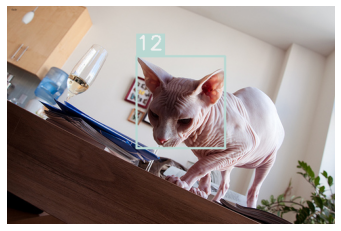

In [6]:
show_record(train_records[1])

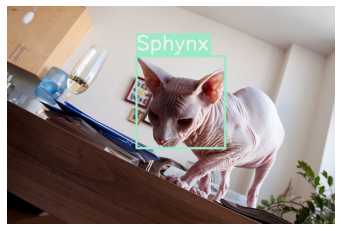

In [7]:
show_record(train_records[1], class_map=class_map)

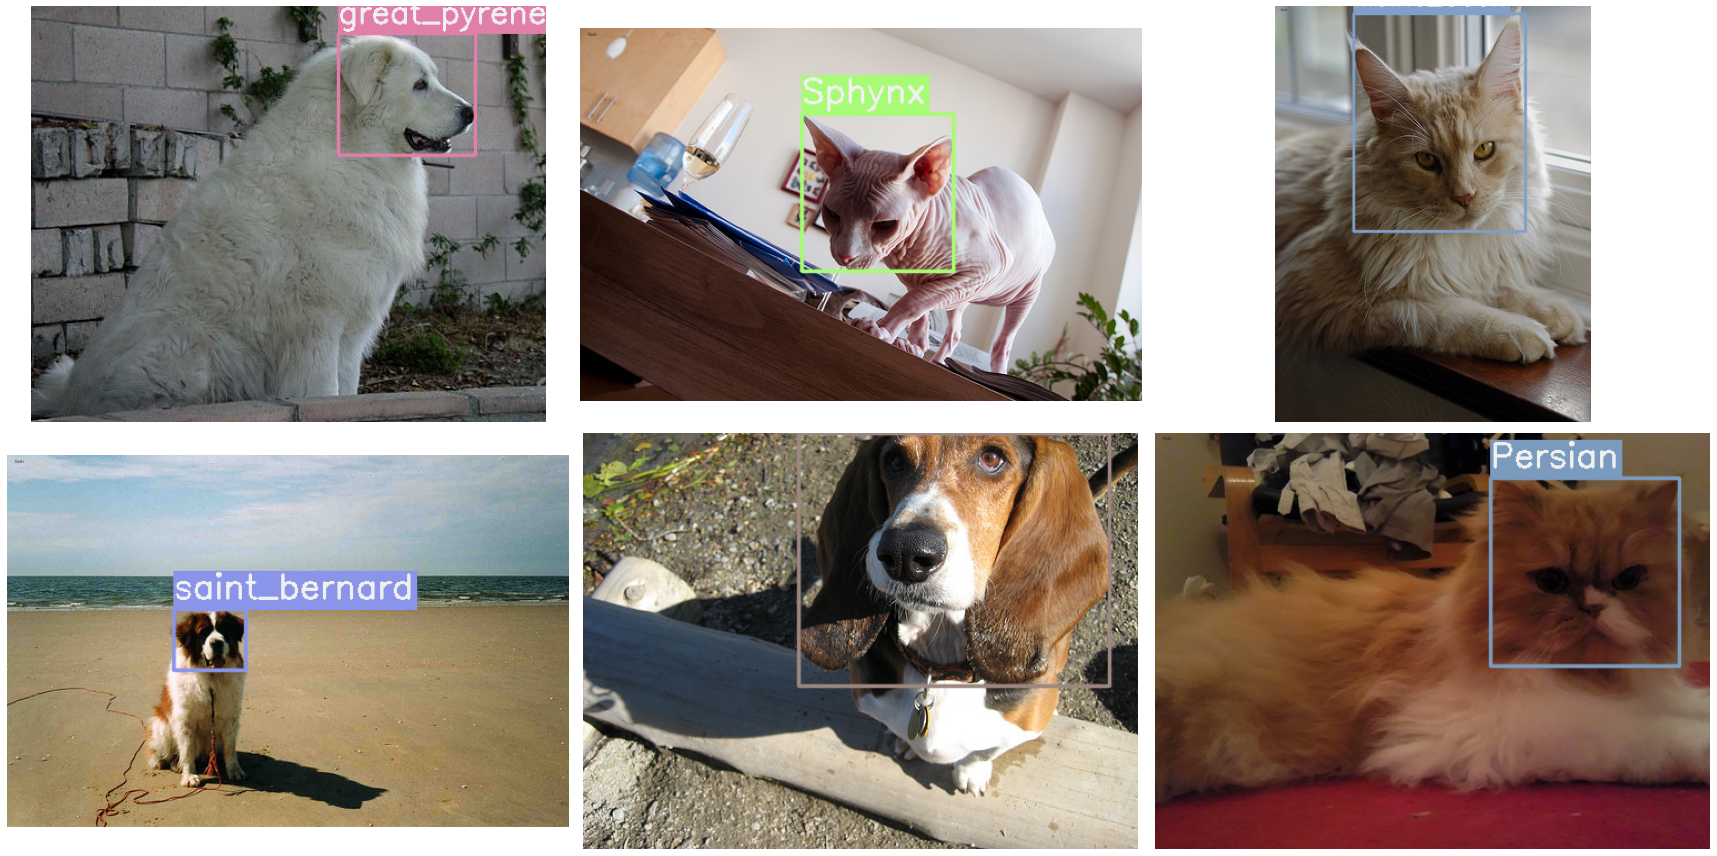

In [8]:
records = train_records[:6]
show_records(records, ncols=3, class_map=class_map)

Data transformations are an essential part of the training pipeline. IceVision supports the widely used albumentations library out-of-the-box.

In [9]:
presize = 512
size = 384

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [10]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

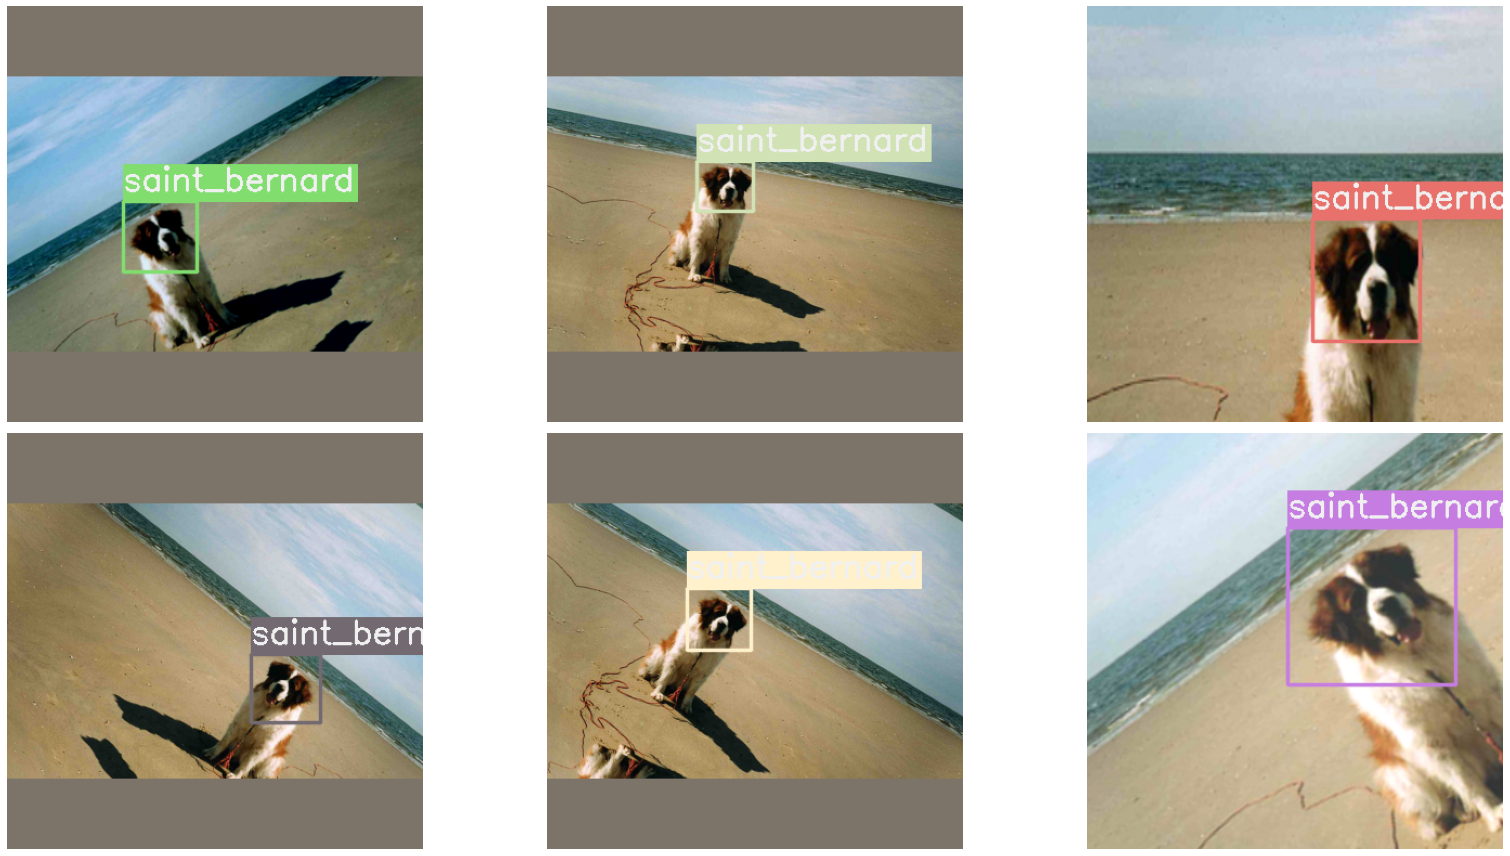

In [11]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

In this tutorial, we are learning to predict bounding boxes and classes. We will use the FasterRCNN model. To create the model, we need to specify how many classes our dataset has. This is the length of the class_map. 



In [12]:
model = faster_rcnn.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [13]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

IceVision is an agnostic framework meaning it can be plugged to multiple DL frameworks such as fastai, and pytorch-lightning. 

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [14]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

Creating a fastai compatible Learner using the fastai interface.

In [15]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

In September 2020, if everything is working, the model might require around 3 minutes per epoch on a free Google Colab server.

In [16]:
learn.fine_tune(10, lr=1e-4)

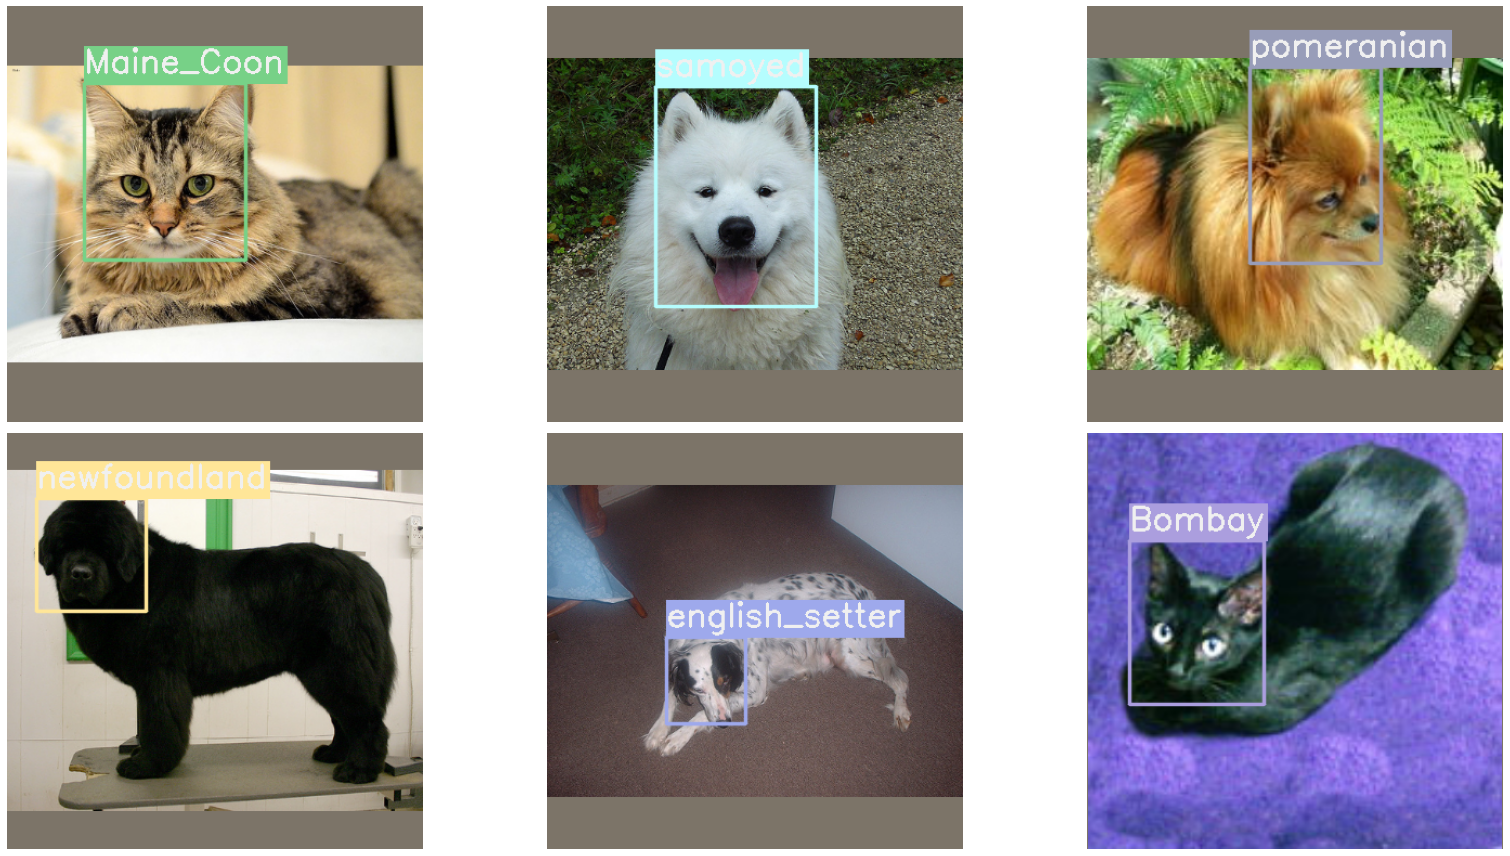

In [17]:
faster_rcnn.show_results(model, valid_ds, class_map=class_map)